<h1> Import data libraries

In [22]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

<h1> Load data

In [23]:
train_data = pd.read_csv('https://www.dropbox.com/s/8pnfe5bnbe9jglt/JobChangeofDataScientists.csv?dl=1') 

<h1> Exploratory Data Analysis

In [24]:
train_data.head(300)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,12934,city_114,0.926,Male,Has relevent experience,Part time course,Graduate,STEM,19,500-999,Pvt Ltd,2,64,0
296,30400,city_73,0.754,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,10000+,Pvt Ltd,1,51,0
297,26419,city_67,0.855,Female,Has relevent experience,Full time course,Graduate,STEM,6,1000-4999,Pvt Ltd,2,41,0
298,4188,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,20,100-500,Pvt Ltd,>4,150,0


In [25]:
train_data.shape

(19158, 14)

It looks like some values in the dataset are NaN, we would like to further inspect to which extent it affects our data.

In [26]:
print("Missing values in the train dataset:\n\n",train_data.isna().sum())

Missing values in the train dataset:

 enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


Let's plot all the column into barcharts to see the distribution of values. As we want our chart to be accesible, we will use colorblind palette. 👀

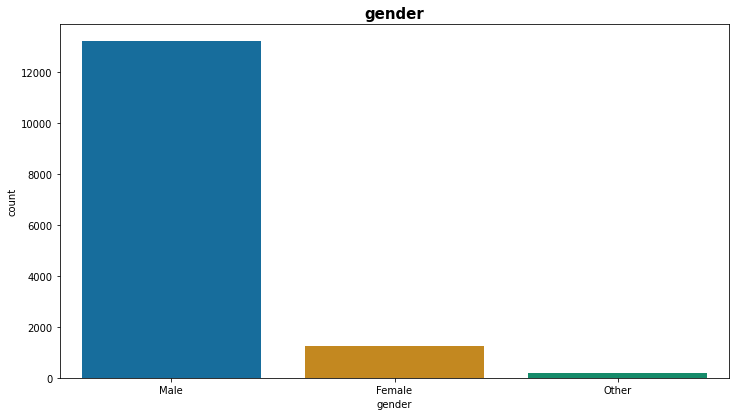

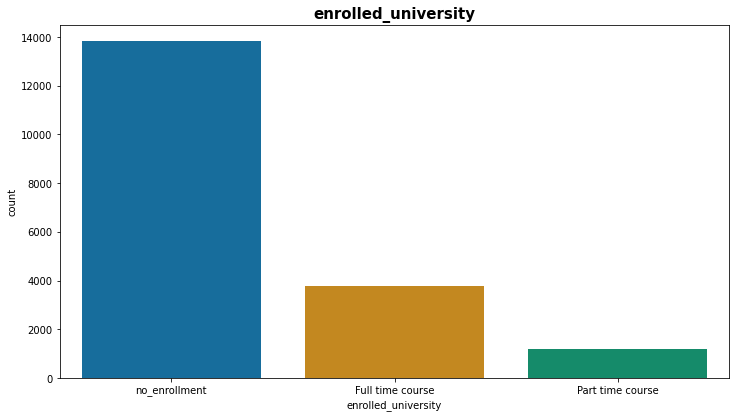

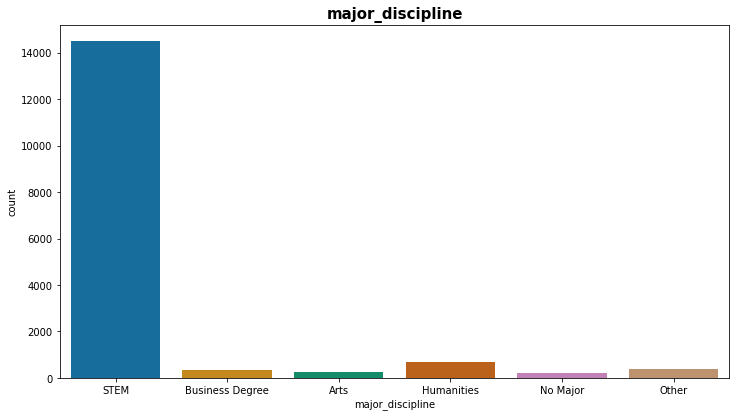

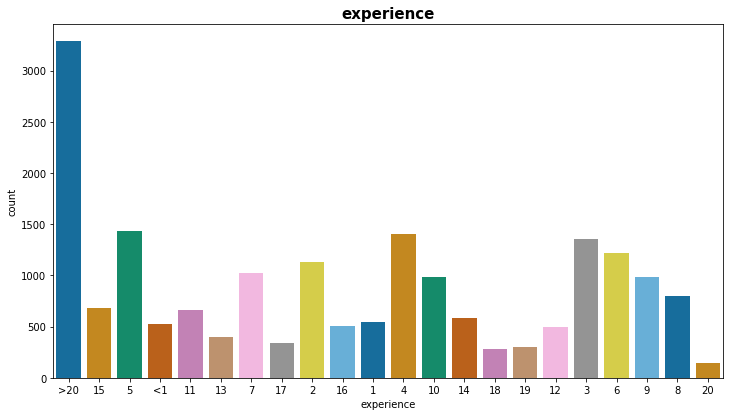

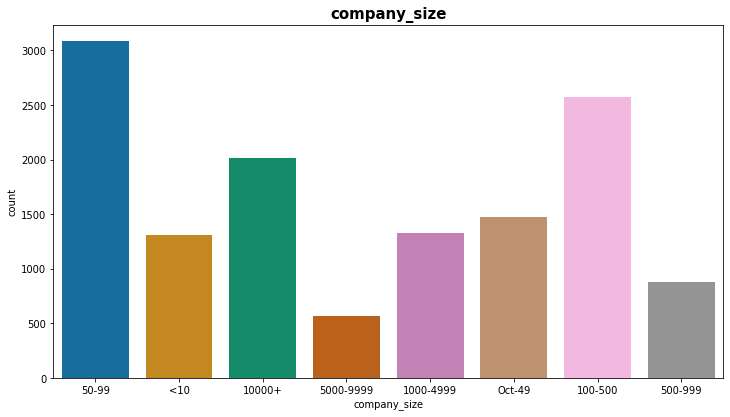

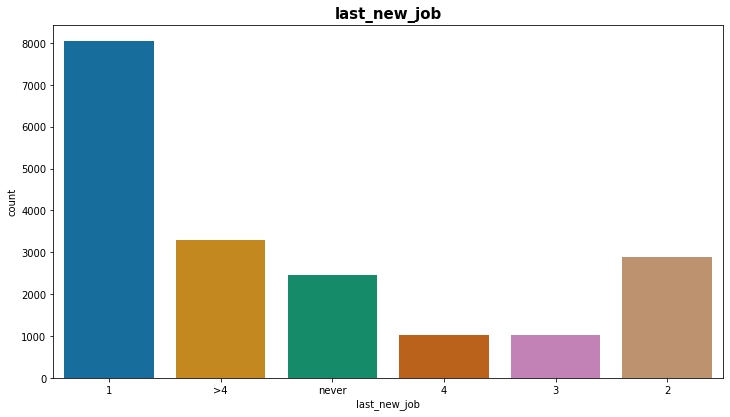

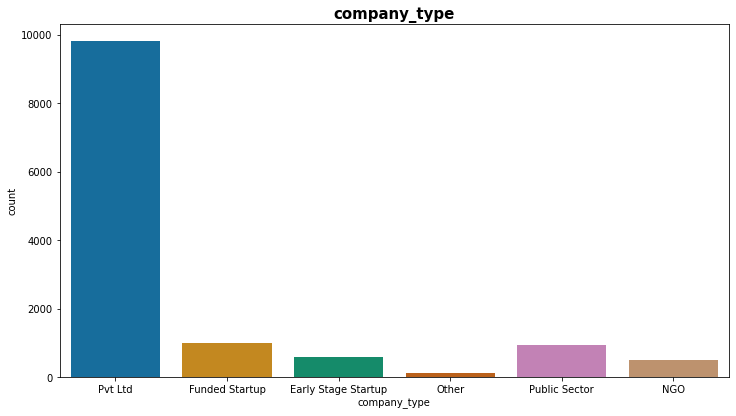

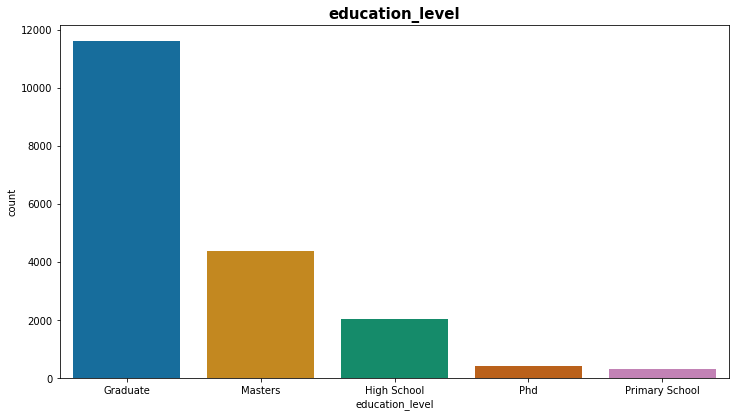

In [27]:
cols_with_nan_data = train_data[['gender', 'enrolled_university', 'major_discipline', 'experience', 'company_size', 'last_new_job', 'company_type', 'education_level']]   
colorblind_palette = sns.color_palette("colorblind")

for i in cols_with_nan_data:
    plt.figure(figsize=(12,6.5)) 
    plt.title(i, fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
    sns.countplot(data = train_data[i], x = cols_with_nan_data[i], palette=colorblind_palette)
    plt.show()

We are also interested in whether the target variable is balanced or not.

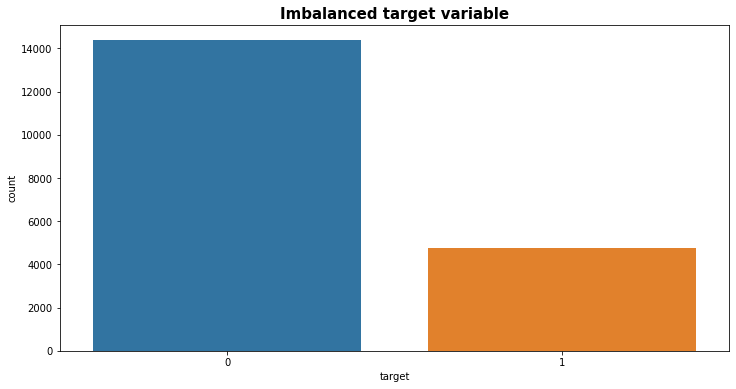

In [28]:
plt.figure(figsize=(12,6))
plt.title("Imbalanced target variable", fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
ax = sns.countplot(x='target', data=train_data)

**From the information we've learned about our dataset, we have to deal with the following challenges:**
* There are NaN values in some attributes  that we need to replace properly (new category, replace with most frequent values, median, mean,...)
* The target variable "target" is highly unbalanced, it needs to be balanced in order to be able to implement ML with fair results

<h1> Data wrangling

<h2>Handling null values

In [29]:
data=train_data
data.shape

(19158, 14)

Now we will take care of all attributes with NaN values as shown in graphs above.

In [30]:
data['city'] = data['city'].str.split("_",expand=True)[1].astype('int64')
data['gender'] = data['gender'].replace(np.nan, 'Male')
data['enrolled_university'] = data['enrolled_university'].replace(np.nan, 'no_enrollment')
data['education_level'] = data['education_level'].replace(np.nan,'Graduate')
data['major_discipline'] = data['major_discipline'].replace(np.nan,'STEM')
data['experience'] = data['experience'].replace(np.nan,'>20')
data['company_size'] = data['company_size'].replace(np.nan,'50-99')
data['company_type'] = data['company_type'].replace(np.nan,'Pvt Ltd')
data['last_new_job'] = data['last_new_job'].replace(np.nan,'1')

Since value 'Other' has very low frequency in gender attribute, we will get rid of it.

In [31]:
data = data[data.gender != 'Other']

In [32]:
data.shape

(18967, 14)

We've successfully replaced all NaN values:

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18967 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18967 non-null  int64  
 1   city                    18967 non-null  int64  
 2   city_development_index  18967 non-null  float64
 3   gender                  18967 non-null  object 
 4   relevent_experience     18967 non-null  object 
 5   enrolled_university     18967 non-null  object 
 6   education_level         18967 non-null  object 
 7   major_discipline        18967 non-null  object 
 8   experience              18967 non-null  object 
 9   company_size            18967 non-null  object 
 10  company_type            18967 non-null  object 
 11  last_new_job            18967 non-null  object 
 12  training_hours          18967 non-null  int64  
 13  target                  18967 non-null  int64  
dtypes: float64(1), int64(4), object(9)
mem

<h2> Conversion of categorical variables into numeric variables

In [34]:
pd.options.mode.chained_assignment = None
ordinal_atributes = ['education_level', 'experience', 'company_size', 'last_new_job']

cardinal_atributes = ['gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']

ordinal_pipeline = Pipeline([
    ('OrdinalEncoder',OrdinalEncoder(categories=[
                                    ['Unknown', 'Primary School',  'High School', 'Graduate', 'Masters', 'Phd'],
                                    'Unknown,<1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,>20'.split(','),
                                    ['Unknown','<10', '10/49', '50-99','Oct-49', '100-500', '500-999' ,'1000-4999', '5000-9999', '10000+'],
                                    ['Unknown','1', '2', '3', '4', '>4', 'never']
                                ]))
])

ordinal_pipeline.fit(data[ordinal_atributes])
data[ordinal_atributes] = ordinal_pipeline.transform(data[ordinal_atributes])
data = pd.get_dummies(data, columns=cardinal_atributes)
data.head()

,enrollee_id,city,city_development_index,education_level,experience,company_size,last_new_job,training_hours,target,gender_Female,...,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
0,8949,103,0.920,3.0,22.0,3.0,1.0,36,1,0,...,0,0,0,1,0,0,0,0,0,1
1,29725,40,0.776,3.0,16.0,3.0,5.0,47,0,0,...,0,0,0,1,0,0,0,0,0,1
2,11561,21,0.624,3.0,6.0,3.0,6.0,83,0,0,...,0,0,0,1,0,0,0,0,0,1
3,33241,115,0.789,3.0,1.0,3.0,6.0,52,1,0,...,0,0,0,0,0,0,0,0,0,1
4,666,162,0.767,4.0,22.0,3.0,4.0,8,0,0,...,0,0,0,1,0,1,0,0,0,0


Let's check how many columns do we have at this moment.

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18967 entries, 0 to 19157
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   enrollee_id                                  18967 non-null  int64  
 1   city                                         18967 non-null  int64  
 2   city_development_index                       18967 non-null  float64
 3   education_level                              18967 non-null  float64
 4   experience                                   18967 non-null  float64
 5   company_size                                 18967 non-null  float64
 6   last_new_job                                 18967 non-null  float64
 7   training_hours                               18967 non-null  int64  
 8   target                                       18967 non-null  int64  
 9   gender_Female                                18967 non-null  uint8  
 10

<h2> Balancing target variable

To balance our target variable, we will use RandomOverSampler from imblearn library.

In [36]:
columns = data.columns.tolist()
columns = [c for c in columns if c not in ['target']]
y = data['target']
X = data[columns]

ros = RandomOverSampler(sampling_strategy='minority')
X_balanced, y_balanced = ros.fit_resample(X, y)
print(f"Imbalanced target class: {Counter(y)}\n\nBalanced target class: {Counter(y_balanced)}\n")
print(X_balanced.shape[0] - data.shape[0], 'new random picked points')

Imbalanced target class: Counter({0: 14240, 1: 4727})

Balanced target class: Counter({1: 14240, 0: 14240})

9513 new random picked points


We can see our result in barchart below 📊 ->

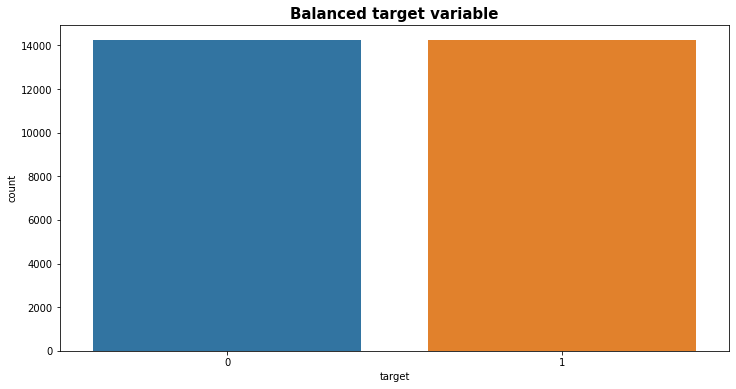

In [37]:
plt.figure(figsize=(12,6))
plt.title("Balanced target variable", fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
ax = sns.countplot(x=y_balanced, data=data)

Perfect! Our dataset is now balanced. 😎

Our dataset is all set and ready to be used in various ML models! 🔎

<h1> Models

In [38]:
X_ros,X_test,y_ros,y_test = train_test_split(X_balanced, y_balanced,test_size=0.3,random_state=1)
X_ros.shape,X_test.shape,y_ros.shape,y_test.shape

((19936, 27), (8544, 27), (19936,), (8544,))

**KNN**

In [39]:
knnc = KNeighborsClassifier(n_neighbors=4)
knnc.fit(X_ros, y_ros)
y_pred_knnc = knnc.predict(X_test)

print(classification_report(y_test, y_pred_knnc))
print("Accuracy score of KNN : {:.2f}".format(accuracy_score(y_pred_knnc,y_test)))
print("Recall score of KNN: {:.2f}".format(recall_score(y_pred_knnc,y_test,average='macro',zero_division=True)))
print("Precision score of KNN: {:.2f}".format(precision_score(y_pred_knnc,y_test,zero_division = True)))
print("F1 score of KNN: {:.2f}".format(f1_score(y_pred_knnc,y_test,zero_division=True)))

              precision    recall  f1-score   support

           0       0.65      0.69      0.67      4232
           1       0.68      0.64      0.65      4312

    accuracy                           0.66      8544
   macro avg       0.66      0.66      0.66      8544
weighted avg       0.66      0.66      0.66      8544

Accuracy score of KNN : 0.66
Recall score of KNN: 0.66
Precision score of KNN: 0.64
F1 score of KNN: 0.65


In [40]:
params = {'n_neighbors': np.arange(1, 31, 2), "metric": ["euclidean"]}
grid_search_cv = GridSearchCV(KNeighborsClassifier(), params, verbose=1, cv=3)
grid_search_cv.fit(X_ros, y_ros)
# returns the best model
grid_search_cv.best_estimator_
# the best parameters
grid_search_cv.best_params_
# results obtained by the best model
knn_accuracy = grid_search_cv.best_score_ 
print('The accuracy score with using the tuned KNN is: ', knn_accuracy)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
The accuracy score with using the tuned KNN is:  0.7541132212643241


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


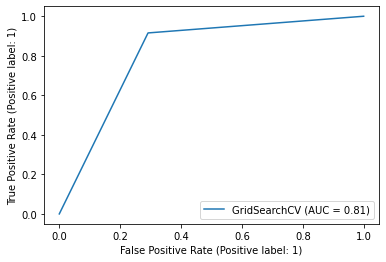

In [41]:
plot_roc_curve(grid_search_cv, X_test, y_test)

**DECISION TREE**

In [42]:
dtc = DecisionTreeClassifier(max_depth = 3, random_state=0)
dtc.fit(X_ros, y_ros)
y_pred_dtc = dtc.predict(X_test)
#metrics.accuracy_score(y_test, y_pred_dtc)

print(classification_report(y_test, y_pred_dtc))
print("Accuracy score of Decision tree : {:.2f}".format(accuracy_score(y_pred_dtc,y_test)))
print("Recall score of Decision tree: {:.2f}".format(recall_score(y_pred_dtc,y_test,average='macro',zero_division=True)))
print("Precision score of Decision tree: {:.2f}".format(precision_score(y_pred_dtc,y_test,zero_division = True)))
print("F1 score of Decision tree: {:.2f}".format(f1_score(y_pred_dtc,y_test,zero_division=True)))

              precision    recall  f1-score   support

           0       0.75      0.52      0.61      4232
           1       0.64      0.83      0.72      4312

    accuracy                           0.67      8544
   macro avg       0.69      0.67      0.66      8544
weighted avg       0.69      0.67      0.66      8544

Accuracy score of Decision tree : 0.67
Recall score of Decision tree: 0.69
Precision score of Decision tree: 0.83
F1 score of Decision tree: 0.72


**Hyperparameter tuning**

In [43]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_ros, y_ros)
# returns the best model
grid_search_cv.best_estimator_
# the best parameters
grid_search_cv.best_params_
# results obtained by the best model
dt_accuracy = grid_search_cv.best_score_ 
print('The accuracy score with using the tuned decision tree classifier is: ', dt_accuracy)

Fitting 3 folds for each of 294 candidates, totalling 882 fits
The accuracy score with using the tuned decision tree classifier is:  0.7482439429801987


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


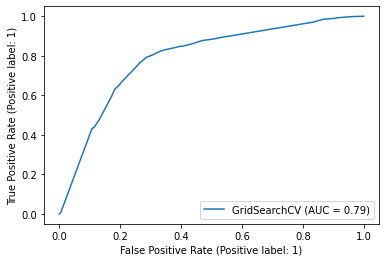

In [44]:
plot_roc_curve(grid_search_cv, X_test, y_test)

**RANDOM FOREST**

In [45]:
rfc = RandomForestClassifier(n_estimators = 50, class_weight = {0:1, 1:4})
rfc.fit(X_ros, y_ros)
y_pred_rfc = rfc.predict(X_test)

print(classification_report(y_test, y_pred_rfc))
print("Accuracy score of Random forest : {:.2f}".format(accuracy_score(y_pred_rfc,y_test)))
print("Recall score of Random forest : {:.2f}".format(recall_score(y_pred_rfc,y_test,average='macro',zero_division=True)))
print("Precision score of Random forest : {:.2f}".format(precision_score(y_pred_rfc,y_test,zero_division = True)))
print("F1 score of Random forest : {:.2f}".format(f1_score(y_pred_rfc,y_test,zero_division=True)))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      4232
           1       0.85      0.94      0.89      4312

    accuracy                           0.89      8544
   macro avg       0.89      0.89      0.89      8544
weighted avg       0.89      0.89      0.89      8544

Accuracy score of Random forest : 0.89
Recall score of Random forest : 0.89
Precision score of Random forest : 0.94
F1 score of Random forest : 0.89


In [46]:
params = {'max_leaf_nodes': list(range(2, 20)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_ros, y_ros)

grid_search_cv.best_estimator_
grid_search_cv.best_params_
rf_accuracy = grid_search_cv.best_score_ 
print('The accuracy score with using the tuned Random Forest is :',rf_accuracy)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
The accuracy score with using the tuned Random Forest is : 0.7230633624884245


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


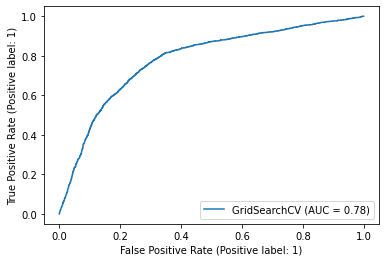

In [47]:
plot_roc_curve(grid_search_cv, X_test, y_test)

**XGB CLASSIFIER**

In [48]:
xgbc = XGBClassifier(use_label_encoder=False)
xgbc.fit(X_ros,y_ros)
y_pred_xgbc = xgbc.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgbc.predict(X_test))

print(classification_report(y_test, y_pred_xgbc))
print("Accuracy score of XGBclassifier : {:.2f}".format(accuracy_score(y_pred_xgbc,y_test)))
print("Recall score of XGBclassifier : {:.2f}".format(recall_score(y_pred_xgbc,y_test,average='macro',zero_division=True)))
print("Precision score of XGBclassifier : {:.2f}".format(precision_score(y_pred_xgbc,y_test,zero_division = True)))
print("F1 score of XGBclassifier : {:.2f}".format(f1_score(y_pred_xgbc,y_test,zero_division=True)))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      4232
           1       0.75      0.77      0.76      4312

    accuracy                           0.75      8544
   macro avg       0.75      0.75      0.75      8544
weighted avg       0.75      0.75      0.75      8544

Accuracy score of XGBclassifier : 0.75
Recall score of XGBclassifier : 0.75
Precision score of XGBclassifier : 0.77
F1 score of XGBclassifier : 0.76


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


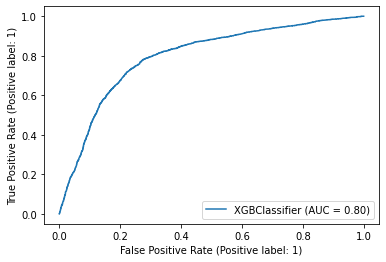

In [49]:
plot_roc_curve(xgbc, X_test, y_test)

# Comparison of Models

Let's check out which one out of our models has the best accuracy score.

In [50]:
accuracies = {"Decision Tree Accuracy":dt_accuracy,  "Random Forest Accuracy":accuracy_score(y_pred_rfc,y_test), "XGB Accuracy":xgb_accuracy, "KNN Accuracy":knn_accuracy}
print("The best score has the model: ", max(accuracies, key=accuracies.get))

The best score has the model:  Random Forest Accuracy


Random forest model has clearly the highest accuracy. Let's now check how good were the other ones!

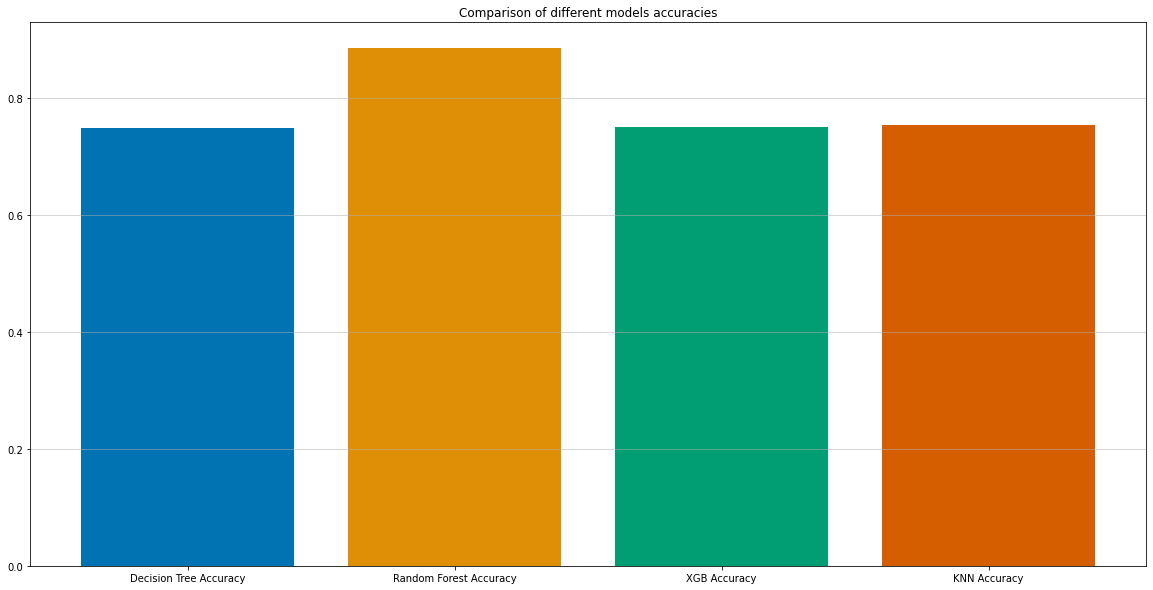

In [51]:
plt.figure(figsize=(20,10))
plt.bar(*zip(*accuracies.items()), color=colorblind_palette, width = 0.8)
plt.title("Comparison of different models accuracies")
plt.grid(axis = 'y', linewidth = 0.5)
plt.show()